<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using physics informed neural networks (PINNs) to solve Navier-Stokes equation.

forked from
https://github.com/janblechschmidt/PDEsByNNs

In this notebook, we illustrate physics informed neural networks (PINNs) to solve partial differential equations (PDEs) as proposed in

- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations*. [arXiv 1711.10561](https://arxiv.org/abs/1711.10561)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations*. [arXiv 1711.10566](https://arxiv.org/abs/1711.10566)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. J. Comp. Phys. 378 pp. 686-707 [DOI: 10.1016/j.jcp.2018.10.045](https://www.sciencedirect.com/science/article/pii/S0021999118307125)

This notebook is partially based on another implementation of the PINN approach published on [GitHub by pierremtb](https://github.com/pierremtb/PINNs-TF2.0) as well as the original code, see [Maziar Raissi on GitHub](https://github.com/maziarraissi/PINNs).

See original notebook here:

<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## PINN for the Navier-Stokes equation

To illustrate the PINN approach we consider the two-dimensional Navier-Stokes equation on the spatial domain $\mathcal{D} = [-15,25]\times[-8,8]$

$$
\begin{aligned}
    \partial_t u + \lambda_1(u \, \partial_x u+v \, \partial_y u)&=  - \partial_x p+ \lambda_2(\partial_{xx} u +\partial_{yy} u), \quad &&\quad (t,x,y) \in (0,1] \times \mathcal{D},\\
    \partial_t v + \lambda_1(u \, \partial_x v+v \, \partial_y v)&=  - \partial_y p+ \lambda_2(\partial_{xx} v +\partial_{yy} v), \quad &&\quad (t,x,y) \in (0,1] \times \mathcal{D},\\
   u(0,x,y) &= - \sin(\pi \, x)\sin(\pi \, y),                 \quad &&\quad (x,y) \in [-15,25]\times[-8,8],\\
   u(t,x,-8) = u(t,x,8) &= 0,                      \quad &&\quad t \in (0,1],\ x\in[-15,25]\\
   u(t,-15,y) &=\text{uniform free stream velocity},                      \quad &&\quad t \in (0,1],\ y\in[-8,8]\\
    u(t,25,y) &= \text{zero pressure outflow},                      \quad &&\quad t \in (0,1],\ y\in[-8,8].
\end{aligned}
$$

In the forward problem (reference problem), we take $\lambda_1 =1$ and $\lambda_2=0.01$.

Solutions to the Navier-Stokes equations are searched in the set of divergence-free functions

$u_x+v_y=0$

We assume $u=\psi_y,\ v = -\psi_x$

The Physcis-informed NN $[f(t,x,y),\ g(t,x,y)]$ approximates $[\psi(t,x,y),\ p(t,x,y)]$, sharing the same parameters $(t,x,y,u,v)$ (and $\lambda_{1,2}$ if inverse problem). Here

$f:= \partial_t u + \lambda_1(u \, \partial_x u+v \, \partial_y u)+  \partial_x p-\lambda_2(\partial_{xx} u +\partial_{yy} u)$

and

$g:= \partial_t v + \lambda_1(u \, \partial_x v+v \, \partial_y v)+ \partial_y p- \lambda_2(\partial_{xx} v +\partial_{yy} v)$

The initial and boundary conditiosn are imposed on the solution $[\psi(t,x,y),\ p(t,x,y)]$.

### 1. Import necessary packages and set problem specific data
This code runs with TensorFlow default version from Google Colab.
The implementation relies mainly on the scientific computing library [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) and the machine learning library [TensorFlow](https://www.tensorflow.org/).

All computations were performed on Google Colab within a couple of minutes.

In [11]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE)

lambda_1 = tf.constant(1.0, dtype=DTYPE)
lambda_2 = tf.constant(1.0, dtype=DTYPE)

# # Initialize parameters if identification problem

# lambda_1 = tf.Variable(1.0, dtype=DTYPE)
# lambda_2 = tf.Variable(1.0, dtype=DTYPE)

# Define initial condition
def fun_0(x, y):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * y)
    return [psi, p]

# Define boundary condition-- for y = 8 and -8 <--------------------------- ask
def fun_lx(t, x):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * t)
    return [psi, p]

# Define boundary condition-- for x = 25 and -15 <--------------------------- ask
def fun_ly(t, y):
    psi = -tf.sin(2 * t)
    p = tf.sin(3. * y)
    return [psi, p]
# Define boundary condition-- for y = 8 and -8 <--------------------------- ask
def fun_ux(t, x):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * t)
    return [psi, p]

# Define boundary condition-- for x = 25 and -15 <--------------------------- ask
def fun_uy(t, y):
    psi = -tf.sin(2 * t)
    p = tf.sin(3. * y)
    return [psi, p]

# Residual of the PDE is defined in fun_r
# all variables: t,x,u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p, p_x, p_y
def fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
  f = u_t + lambda_1 * (u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)
  g = v_t + lambda_1 * (u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)
  return [f, g]

### 2. Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
Our numerical experiments indicate that this strategy slightly improves the observed convergence rate, but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [22]:
# Set number of data points
N_0 = 200
N_b = 200
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -15.
xmax = 25.
ymin = -8.
ymax = 8.

# Lower bounds
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0,1), lb[2], ub[2], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0, y_0], axis=1)

# Boundary data points
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
y_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[2]
y_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[2]

X_lb = tf.concat([t_b, x_lb, y_0], axis=1)
X_ub = tf.concat([t_b, x_ub, y_0], axis=1)
Y_lb = tf.concat([t_b, x_0, y_lb], axis=1)
Y_ub = tf.concat([t_b, x_0, y_ub], axis=1)

# Evaluate initial condition at x_0
pp_0 = fun_0(x_0, y_0)

# Evaluate boundary condition at (t_b, x_b, y_b) <---------- to fix
pp_lx = fun_lx(t_b, x_lb)
pp_ly = fun_ly(t_b, y_lb)
pp_ux = fun_lx(t_b, x_ub)
pp_uy = fun_ly(t_b, y_ub)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_lb, X_ub, Y_lb, Y_ub]
pp_data = [pp_0, pp_lx, pp_ux, pp_ly, pp_uy]

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

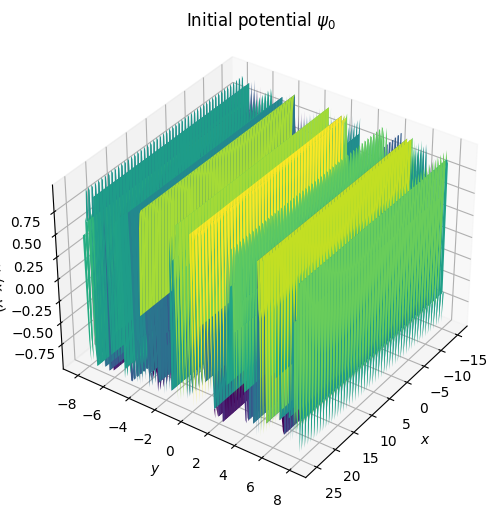

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Set up meshgrid
N = 200
tspace = np.linspace(lb[0], ub[0], N)#N + 1)
xspace = np.linspace(lb[1], ub[1], N)#N + 1)
yspace = np.linspace(lb[2], ub[2], N)#N + 1)
# T, X, Y = np.meshgrid(tspace, xspace, yspace)
# Xgrid = np.vstack([T.flatten(),X.flatten(),Y.flatten()]).T
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T


# Surface plot of initial condition u_0
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, pp_0[1], cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_0(x,y)$')
ax.set_title('Initial potential $\psi_0$');

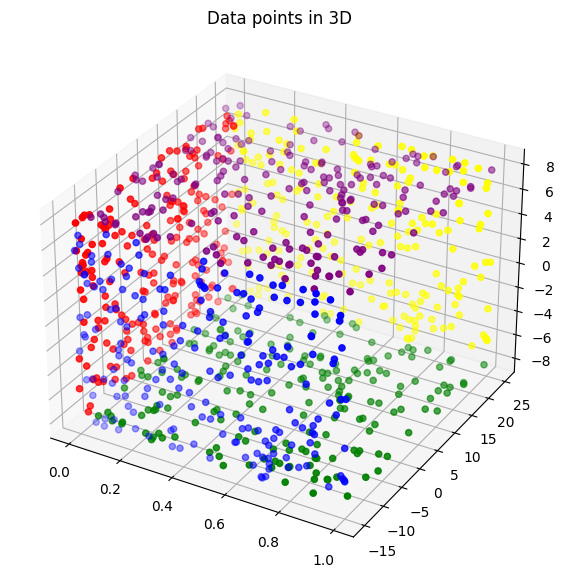

In [26]:
# Import libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(t_0, x_0, y_0, color = "red")
ax.scatter3D(t_b, x_lb, y_0, color = "blue")
ax.scatter3D(t_b, x_ub, y_0, color = "yellow")
ax.scatter3D(t_b, x_0, y_lb, color = "green")
ax.scatter3D(t_b, x_0, y_ub, color = "purple")
# ax.scatter3D(t_r, x_r, y_r, color = "black")
plt.title("Data points in 3D")

# show plot
plt.show()

#plt.savefig('Xdata_navier.pdf', bbox_inches='tight', dpi=300)

### 3. Set up network architecture

In this example, adopted from
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [28]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + two spatial dimensions)
    model.add(tf.keras.Input(3))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))

    return model

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Navier Stokes equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$, $\partial_y u_\theta$, $\partial_{xx} u_\theta$, $\partial_{yy} u_\theta$, $\partial_t v_\theta$, $\partial_x v_\theta$, $\partial_y v_\theta$, $\partial_{xx} v_\theta$, $\partial_{yy} v_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t`, `x` and `y`, in order to compute the derivatives.

In [7]:
def get_r(model, X_r)-> tf.Tensor:

# A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]

        # Variables t x and y are watched during tape
        # to compute partial derivatives of u and v
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        pp = model(tf.stack([t[:,0], x[:,0]], y[:,0], axis=1))
        psi = pp[:, 0:1]
        p = pp[:, 1:2]

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u = tape.gradient(psi,y)
        v = -tape.gradient(psi,x)

        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)

        v_x = tape.gradient(v,x)
        v_y = tape.gradient(v,y)

    p_x = tape.gradient(p,x)
    p_y = tape.gradient(p,y)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    v_t = tape.gradient(v,t)
    v_xx = tape.gradient(v_x,x)
    v_yy = tape.gradient(v_y,y)

    del tape

    # f_u = u_t + lambda_1*(u * u_x + v * u_y) + p_x - lambda_2*(u_xx + u_yy)
    # f_v = v_t + lambda_1*(u * v_x + v * v_y) + p_y - lambda_2*(v_xx + v_yy)

    return fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y)
    # return u, v, p, f_u, f_v

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `pp_data = [pp_0, pp_bx, pp_by]`.

In [29]:
def compute_loss(model, X_r, X_data, pp_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss with interior point loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        pp_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(pp_data[i] - pp_pred))

    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [30]:
def get_grad(model, X_r, X_data, pp_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables of the neural net
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, pp_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [31]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [32]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, pp_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 2000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

TypeError: ignored

### Plot solution

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Plot the evolution of loss

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

## Class implementation of PINNs

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.

In [ ]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=1,
            num_hidden_layers=8,
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


Next, we derive a class `PINNSolver` which can be used as a base class.
It possesses two methods to solve the PDE:
  1. the method `solve_with_TFoptimizer` uses a `TensorFlow` optimizer object as input, e.g., the `AdamOptimizer` above;
  2. the method `solve_with_LBFGS` resembles the LBFGS method proposed in the original paper using an LBFGS method provided by [`SciPy`](https://www.scipy.org/).

In [ ]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss

    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - viscosity * u_xx

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

### Burgers equation with L-BFGS

The following code cell shows how the new classes `PINN_NeuralNet` and `PINNSolver` can be used to solve the Burgers equation, this time using the `SciPy` implementation of L-BFGS (takes around 3 minutes).

In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,2))

# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=4001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Plot solution and loss history.

In [ ]:
solver.plot_solution();
solver.plot_loss_history();